# MODFLOW 6: simulación de flujo v 1.0


## Resumen.
Se realiza una simulación de flujo en dos dimensiones explicando paso a paso el proceso, similar a lo realizado en la notebook [02_GWF_paq.ipynb](02_GWF_paq.ipynb) pero con una conductividad hidráulica variable. Adicionalmente, se encapsulan en una función de python varias acciones para hacer más modular la simulación.

<p xmlns:cc="http://creativecommons.org/ns#" xmlns:dct="http://purl.org/dc/terms/"><a property="dct:title" rel="cc:attributionURL" href="https://github.com/luiggix/mf6_tutorial/">MODFLOW 6: tutorial</a> (0_mf6/02_GWF_v1.ipynb) by <b>Luis M. de la Cruz Salas (2025)</b> is licensed under <a href="http://creativecommons.org/licenses/by-sa/4.0/?ref=chooser-v1" target="_blank" rel="license noopener noreferrer" style="display:inline-block;">Attribution-ShareAlike 4.0 International<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a>.</p> 

# Introducción.

Usando las herramientas de Flopy es posible generar los archivos de entrada para MODFLOW de una forma más simple y automatizada. Además, dentro del ambiente de Python se pueden construir estructuras de datos que permiten definir los parámetros de la simulación y modificarlos fácilmente. Dado que usando Flopy se tiene una secuencia bien definida para crear la simulación y construir los archivos de entrada, en este ejemplo se construye una función que recibe los parámetros adecuados para definir dicha secuencia y regresar los objetos de la simulación y del modelof GWF, con los cuales será posible ejecutar la simulación y posteriormente realizar el post-procesamiento.


<div class="alert alert-block alert-info">

# Ejemplo: Simulación de flujo en 2D con $k$ variable.

En este ejemplo se simula una distribución de carga hidráulica en un dominio rectangular de $15$ m $\times$ $10$ m con una sola capa con espesor de $1$ m.  La carga va de $10$ m en el lado izquierdo a $5$ m en lado derecho, formando un gradiente horizontal de flujo. Los lados superior e inferior del dominio son impermeables. No hay fuentes ni sumideros. El valor de la conductividad hidráulica se genera de manera aleatoria dentro de todo el dominio y se define una sección con una permeabilidad constante.

</div>

## Paso 0. Importación de bibliotecas y módulos.

Debemos incluir todas las bibliotecas que se van a usar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import xmf6
import flopy

## Paso 1. Función `build()`.

La función `build()` define la siguiente secuencia de pasos (véase la sección **Paquetes** en la notebook [00_MF6_Intro.ipynb](00_MF6_Intro.ipynb)):

1. Inicialización de la simulación.
2. Componentes:
    * Tiempos de simulación.
    * Solucionador numérico.
    * Modelo GWF.
3. Paquetes:
    * Discretización espacial (DIS).
    * Condiciones iniciales (IC).
    * Condiciones de frontera (CHD).
    * Propiedades de flujo (NPF).
    * Configuración de la salida (OC).

La función regresa un objeto para la simulación (`o_sim`) y un objeto del modelo GWF (`o_gwf`) y tiene la siguiente forma:

```python
def build(init, time, mesh, ic_data, chd_data, k_data):

    ...

    return o_sim, o_gwf
```

Los parámetros que recibe esta función son los siguientes:

* `init`. Diccionario con los parámetros de configuración de la simulación (nombre del ejecutable, nombre del modelo, espacio de trabajo, etc).
* `time`. Diccionario con los parámetros para la discretización temporal.
* `mesh`. Diccionario con los parámetros para la discretización espacial.
* `ic_data`. Diccionario con los parámetros para las condiciones iniciales.
* `chd_data`. Arreglo (`list`) con los parámetros para las condiciones de frontera.
* `k_data`. Arreglo (`numpy.ndarray`) con los parámetros para las propiedades del flujo.

La función se define en la siguiente celda:

In [2]:
def build(init, time, mesh, ic_data, chd_data, k_data):
    # --- Inicialización de la simulación ---
    o_sim = flopy.mf6.MFSimulation(
        sim_name = init["sim_name"],
        exe_name = init["exe_name"],
        sim_ws   = init["sim_ws"]
    )

    ### --- COMPONENTES ---

    # --- Tiempos de simulación ---
    o_tdis = flopy.mf6.ModflowTdis(
        simulation = o_sim,
        time_units = time["units"],
        nper = time["nper"],
        perioddata = time["perioddata"]
    )
    
    # --- Solucionador numérico (IMS) ---
    o_ims = flopy.mf6.ModflowIms(
        simulation = o_sim,
    )
    
    # --- Modelo GWF ---
    o_gwf = flopy.mf6.ModflowGwf(
        simulation = o_sim,
        modelname = init["sim_name"],
        model_nam_file = f"{init["sim_name"]}.nam",
        save_flows = True # Almacena los flujos, particularmente el budget
    )
    
    ### --- PAQUETES ---

    # --- Discretización espacial ---º
    o_dis = flopy.mf6.ModflowGwfdis(
        model = o_gwf,
        length_units = "METERS",
        nlay = mesh['nlay'],
        nrow = mesh['nrow'],
        ncol = mesh['ncol'],
        delr = mesh['delr'],
        delc = mesh['delc'],
        top  = mesh['top'],
        botm = mesh['botm'],
    )
    
    # --- Condiciones iniciales ---
    o_ic = flopy.mf6.ModflowGwfic(
        model = o_gwf,
        strt = ic_data["strt"]
    )
    
    # --- Condiciones de frontera ---
    o_chd = flopy.mf6.ModflowGwfchd(
        model = o_gwf,
        stress_period_data=chd_data,
    )
    
    # --- Propiedades de flujo ---
    o_npf = flopy.mf6.ModflowGwfnpf(
        model = o_gwf,
        save_specific_discharge = True,
        k = k_data, # conductividad hidráulica
    )
    
    # --- Configuración de la salida ---
    o_oc = flopy.mf6.ModflowGwfoc(
        model = o_gwf,
        budget_filerecord = f"{init["sim_name"]}.bud",
        head_filerecord = f"{init["sim_name"]}.hds",
        saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord = [("HEAD", "ALL")]
    )

    return o_sim, o_gwf

## Paso 2. Parámetros de la simulación. 

Para utilizar la función `build()` necesitamos definir la información que requiere para ser ejecutada usando las estructuras de datos pertinentes. Esta información se construye en las celdas siguientes.

### Diccionarios.

In [3]:
# --- Datos para la configuración de la simulación --- 
# Opciones de SO's: linux, macos, macosarm, windows
init = {
    'exe_name' : "C:\\Users\\luiggi\\Documents\\GitSites\\mf6_tutorial\\mf6\\windows\\mf6",
#    'exe_name' : "../../mf6/macosarm/mf6",
    'sim_name' : "flow",
    'sim_ws' : "sandbox3"
}

# --- Datos para la discretización temporal ---
time = {
    'units': "DAYS",
    'nper' : 1,
    'perioddata': [(1.0, 1, 1.0)]
}

# --- Datos para la discretización espacial ---
dis = {
    'nlay': 1, 
    'nrow': 20, 
    'ncol': 30,
    'delr': 0.5, 
    'delc': 0.5, 
    'top' : 0.0, 
    'botm': -1.0 
}

# --- Datos para las condiciones iniciales ---
ic_data = {
    'strt': 10
}

Se puede ver el contenido de los diccionarios como sigue:

In [4]:
print(init)
print(time)
print(dis)
print(ic_data)

{'exe_name': 'C:\\Users\\luiggi\\Documents\\GitSites\\mf6_tutorial\\mf6\\windows\\mf6', 'sim_name': 'flow', 'sim_ws': 'sandbox3'}
{'units': 'DAYS', 'nper': 1, 'perioddata': [(1.0, 1, 1.0)]}
{'nlay': 1, 'nrow': 20, 'ncol': 30, 'delr': 0.5, 'delc': 0.5, 'top': 0.0, 'botm': -1.0}
{'strt': 10}


### La función `xmf6.nice_print()`.

Esta función imprime los datos de cada diccionario de una forma entendible para el usuario:

In [5]:
xmf6.nice_print(init, "Inicialización de la simulación")
xmf6.nice_print(time, "Discretización temporal")
xmf6.nice_print(dis, "Discretización espacial")
xmf6.nice_print(ic_data, "Condiciones iniciales")


Inicialización de la simulación
―――――――――――――――――――――――――――――――
exe_name = C:\Users\luiggi\Documents\GitSites\mf6_tutorial\mf6\windows\mf6
sim_name = flow
  sim_ws = sandbox3
―――――――――――――――――――――――――――――――

Discretización temporal
―――――――――――――――――――――――
     units = DAYS
      nper = 1
perioddata = ―― data array ――
           = (1.0, 1, 1.0)
―――――――――――――――――――――――

Discretización espacial
―――――――――――――――――――――――
nlay = 1
nrow = 20
ncol = 30
delr = 0.5
delc = 0.5
 top = 0.0
botm = -1.0
―――――――――――――――――――――――

Condiciones iniciales
―――――――――――――――――――――
strt = 10
―――――――――――――――――――――


### Arreglos.
Para los datos de las condiciones de frontera y de la conductividad hidráulica creamos listas y arreglos de numpy como se muestra a continuación:

In [6]:
# --- Datos para las condiciones de frontera ---
chd_data = []
for row in range(dis['nrow']):
    chd_data.append([(0, row, 0), 10.0])       # Condición en la pared izquierda
    chd_data.append([(0, row, dis['ncol'] - 1), 5.0]) # Condición en la pared derecha

print(chd_data)

[[(0, 0, 0), 10.0], [(0, 0, 29), 5.0], [(0, 1, 0), 10.0], [(0, 1, 29), 5.0], [(0, 2, 0), 10.0], [(0, 2, 29), 5.0], [(0, 3, 0), 10.0], [(0, 3, 29), 5.0], [(0, 4, 0), 10.0], [(0, 4, 29), 5.0], [(0, 5, 0), 10.0], [(0, 5, 29), 5.0], [(0, 6, 0), 10.0], [(0, 6, 29), 5.0], [(0, 7, 0), 10.0], [(0, 7, 29), 5.0], [(0, 8, 0), 10.0], [(0, 8, 29), 5.0], [(0, 9, 0), 10.0], [(0, 9, 29), 5.0], [(0, 10, 0), 10.0], [(0, 10, 29), 5.0], [(0, 11, 0), 10.0], [(0, 11, 29), 5.0], [(0, 12, 0), 10.0], [(0, 12, 29), 5.0], [(0, 13, 0), 10.0], [(0, 13, 29), 5.0], [(0, 14, 0), 10.0], [(0, 14, 29), 5.0], [(0, 15, 0), 10.0], [(0, 15, 29), 5.0], [(0, 16, 0), 10.0], [(0, 16, 29), 5.0], [(0, 17, 0), 10.0], [(0, 17, 29), 5.0], [(0, 18, 0), 10.0], [(0, 18, 29), 5.0], [(0, 19, 0), 10.0], [(0, 19, 29), 5.0]]


In [7]:
# --- Datos para las propiedades de flujo ---
# Creamos un arreglo de conductividad hidráulica para toda la malla
k_data = np.random.rand(dis['nlay'], dis['nrow'], dis['ncol'])*1.0 
    
# Asignamos una conductividad constante en una sección del dominio
k_data[:,5:15,10:20] = 0.1

print("k_data")
xmf6.info_array(k_data)
print(k_data)

k_data
 tipo  : <class 'numpy.ndarray'> 
 dtype : float64 
 dim   : 3 
 shape : (1, 20, 30) 
 size(bytes) : 8 
 size(elements) : 600
[[[0.82376576 0.49542045 0.54486243 0.78396227 0.09030223 0.64847058
   0.09027687 0.45573147 0.45172813 0.40082175 0.21581741 0.41541418
   0.52413276 0.28054217 0.06631736 0.96292966 0.15006358 0.63222287
   0.12393863 0.25769359 0.74359369 0.48925315 0.69154448 0.39541706
   0.82789998 0.17939097 0.92863121 0.50564091 0.26336869 0.8377974 ]
  [0.12927085 0.56382325 0.22321806 0.61829807 0.10002505 0.22931935
   0.15315093 0.5190996  0.27410072 0.22697463 0.14530833 0.90196835
   0.19538571 0.50072369 0.14460796 0.13654852 0.30898581 0.64336074
   0.66487412 0.86165649 0.43442666 0.18947765 0.87072474 0.20511925
   0.21846178 0.24380209 0.91877559 0.91849923 0.20731874 0.85240889]
  [0.5766389  0.58416228 0.34941296 0.34345498 0.3949213  0.70012319
   0.99848208 0.51454456 0.26031617 0.93149122 0.28533203 0.58216927
   0.9425624  0.14678208 0.77235601 0

## Paso 3. Inicialización de la simulación. 

Para inicializar los objetos de la simulación  (`o_sim`, `o_gwf`) debemos ejecutar la función `buildU()` como sigue:

In [8]:
# --- Construcción de la simulación y del modelo GWF ---
o_sim, o_gwf = build(init, time, dis, ic_data, chd_data, k_data)

In [9]:
# --- Impresión del estado de la simulación ---
print(o_sim)

sim_name = flow
sim_path = C:\Users\luiggi\Documents\GitSites\mf6_tutorial\examples\0_mf6\sandbox3
exe_name = C:\Users\luiggi\Documents\GitSites\mf6_tutorial\mf6\windows\mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = flow


###################
Package flow.tdis
###################

package_name = flow.tdis
filename = flow.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = flow


###################
Package ims_-1
###################

package_name = ims_-1
filename = flow.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = flow


@@@@@@@@@@@@@@@@@@@@
Model flow
@@@@@@@@@@@@@@@@@@@@

name = flow
model_type = gwf6
version = mf6
model_relative_path = .

###################
Package dis
###################

package_name = dis
filename = flow.dis
package_type = dis
model_or_simulation_package

In [10]:
# --- Impresión del estado del modelo GWF ---
print(o_gwf)

name = flow
model_type = gwf6
version = mf6
model_relative_path = .

###################
Package dis
###################

package_name = dis
filename = flow.dis
package_type = dis
model_or_simulation_package = model
model_name = flow


###################
Package ic
###################

package_name = ic
filename = flow.ic
package_type = ic
model_or_simulation_package = model
model_name = flow


###################
Package chd_0
###################

package_name = chd_0
filename = flow.chd
package_type = chd
model_or_simulation_package = model
model_name = flow


###################
Package npf
###################

package_name = npf
filename = flow.npf
package_type = npf
model_or_simulation_package = model
model_name = flow


###################
Package oc
###################

package_name = oc
filename = flow.oc
package_type = oc
model_or_simulation_package = model
model_name = flow





## Paso 4.  Escritura de archivos.

A través del objeto de la simulación, `o_sim`, escribimos los archivos de entrada para MODFLOW 6:

In [11]:
# --- Escribimos los archivos ---
o_sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 40 based on size of stress_period_data
    writing package npf...
    writing package oc...


## Paso 5. Ejecución de la simulación.

A través del objeto de la simulación, `o_sim`, ejecutamos la simulación:

In [12]:
# --- ejecutamos la simulación ---
o_sim.run_simulation(silent=False)

FloPy is using the following executable to run the model: ..\..\..\mf6\windows\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 10 2025 17:37:25 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Gover

(True, [])

## Paso 6. Recuperación de los resultados.

Los datos los vamos a recuperar de los archivos generados por la simualción, en este caso de `flow.hds` y `flow.bud`.

* La carga hidráulica se almacenará en el arreglo `head`.
* La descarga específica se almacenará en los arreglos `qx`, `qy` y `qz`.

In [13]:
### --- Recuperación de la carga hidráulica ---

# Construimos el nombre con la ruta y extensión correcta
# Tanto el espacio de trabajo como el nombre del modelo de flujo
# se pueden obtener del objeto o_gwf
headfile = os.path.join(o_gwf.model_ws, f"{o_gwf.name}.hds")

# Objeto para obtener y manipular arreglos o series de tiempo de arreglos con datos
# de una o más celdas con información del archivo binario de la carga hidráulica.
hds = flopy.utils.HeadFile(headfile)

# Solo se obtiene la capa 0, cuando no se pone ningún valor en el parámetro mlay se obtienen todas las capas
head = hds.get_data(mflay=0)

### --- Recuperación de la descarga específica ---

# Construimos el nombre con la ruta y extensión correcta
# Tanto el espacio de trabajo como el nombre del modelo de flujo
# se pueden obtener del objeto o_gwf
budfile = os.path.join(o_gwf.model_ws, f"{o_gwf.name}.bud")

# Objeto para obtener y manipular arreglos o series de tiempo de arreglos con datos
# de una o más celdas con información del archivo binario del budget.
bud  = flopy.utils.CellBudgetFile(budfile)

# Cargamos resultados de la descarga específica
spdis = bud.get_data(text="DATA-SPDIS")[0]

# Extraemos las componentes del flujo en un arreglo 3D para graficación
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, o_gwf)

# Calculamos la norma de la descarga específica
n_q = np.sqrt(np.square(qx[0]) + np.square(qy[0]))

En este momento tenemos los siguientes arreglos:
* `head`, carga hidráulica.
* `spdis`, descarga específica en un arreglo de tipo `recarray` con 6 columnas.
* `qx`, `qy`, `qz`, componentes de la descarga específica.
* `n_q`, norma del vector de descarga específica para graficación.

## Paso 7. Visualización de los resultados.

Se visualiza los siguiente:
* Permeabilidad ($k$, `k_data`).
* Carga hidráulica ($h$, `head`).
* Descarga específica ($q$, `(qx, qy)`)


In [14]:
# --- Parámetros para las gráficas
grid = o_gwf.modelgrid
x, y, z = grid.xyzcellcenters
xticks = np.linspace(grid.extent[0], grid.extent[1], 7)
yticks = np.linspace(grid.extent[2], grid.extent[3], 5)
xlabels = [f'{x:1.1f}' for x in xticks]
ylabels = [f'{y:1.1f}' for y in yticks]
kvmin = 1.0 
kvmax = 0.0 
hvmin = np.nanmin(head)
hvmax = np.nanmax(head)
qvmin = 0.00 
qvmax = 0.35 

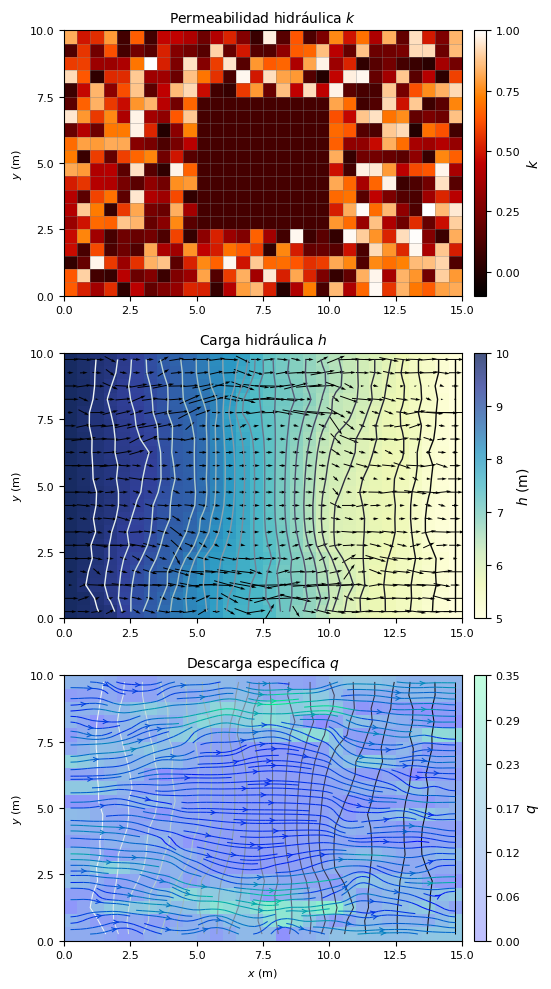

In [15]:
# --- Definición de la figura ---

# Se harán tres gráficas en una sola figura.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize =(10,10))

#--- Gráfica 1. ---
# Mapa visual del modelo. En este caso el modelo es 'o_gwf'. 
kview = flopy.plot.PlotMapView(model = o_gwf, ax = ax1)

# Visualización de la malla, con una transparencia.
kview.plot_grid(linewidths = 0.5, alpha = 0.5)

# Visualización de la permeabilidad hidráulica usando un mapa de color.
k_ac = kview.plot_array(k_data, cmap = "gist_heat", vmin = kvmin, vmax = kvmax)

# Barra de color para la permeabilidad hidráulica.
k_cb = plt.colorbar(k_ac, ax = ax1, label = "$k$", 
                    ticks = [0.0, 0.25, 0.50, 0.75, 1.0],
                    cax = xmf6.vis.cax(ax1, k_ac))
k_cb.ax.tick_params(labelsize=8)

# Personalización de la gráfica.
ax1.set_title("Permeabilidad hidráulica $k$", fontsize=10)
ax1.set_ylabel("$y$ (m)", fontsize = 8)
ax1.set_xticks(ticks = xticks, labels = xlabels, fontsize = 8)
ax1.set_yticks(ticks = yticks, labels = ylabels, fontsize = 8)
ax1.set_aspect('equal')

### Gráfica 2.

# Mapa visual del modelo. En este caso el modelo es 'o_gwf'. 
hview = flopy.plot.PlotMapView(model = o_gwf, ax = ax2)

# Visualización de la carga hidráulica usando un mapa de color.
h_ac = hview.plot_array(head, cmap = "YlGnBu", vmin = hvmin, vmax = hvmax, alpha = 0.75)

# Visualización de la carga hidráulica usando contornos.
hview.contour_array(head, levels = 30, cmap = "bone", linewidths = 1.0)

# Visualización de los vectores de la descarga específica.
ax2.quiver(x, y, qx[0], qy[0], scale = 3, 
           color = 'k', linewidth = 0.95, pivot = 'middle')

# Barra de color para la carga hidráulica.
h_cb = plt.colorbar(h_ac, ax = ax2, label = "$h$ (m)", 
                    cax = xmf6.vis.cax(ax2, h_ac))
h_cb.ax.tick_params(labelsize=8)

# Personalización de la gráfica.
ax2.set_title("Carga hidráulica $h$", fontsize=10)
ax2.set_ylabel("$y$ (m)", fontsize = 8)
ax2.set_xticks(ticks = xticks, labels = xlabels, fontsize = 8)
ax2.set_yticks(ticks = yticks, labels = ylabels, fontsize = 8)
ax2.set_aspect('equal')

### Gráfica 3.

# Mapa visual del modelo. En este caso el modelo es 'o_gwf'.
fview = flopy.plot.PlotMapView(model = o_gwf, ax = ax3)

# Visualización de la descarga hidráulica usando un mapa de color.
q_ac = fview.plot_array(n_q, cmap = "winter", vmin = qvmin, vmax = qvmax, alpha = 0.25)

# Visualización de la carga hidráulica usando contornos.
fview.contour_array(head, levels = 20, cmap = 'bone', linewidths = 0.75, )

# Visualización de líneas de corriente de la descarga específica.
ax3.streamplot(x, y[::-1][:], qx[0], qy[0][::-1], 
               density = [2, 1.5], linewidth = 0.75, broken_streamlines = True, 
               color = n_q, cmap = "winter", 
               arrowstyle = "->", arrowsize = 0.75,  )

# Barra de color para la norma de la descarga hidráulica.
q_cb = plt.colorbar(q_ac, ax=ax3, label="$q$", 
                    ticks = np.linspace(0.0, 0.35, 7),
                    format = "{x:3.2f}",
                    cax = xmf6.vis.cax(ax3, q_ac))
q_cb.ax.tick_params(labelsize=8)

# Personalización de la gráfica.
ax3.set_title("Descarga específica $q$", fontsize=10)
ax3.set_xlabel("$x$ (m)", fontsize = 8)
ax3.set_ylabel("$y$ (m)", fontsize = 8)
ax3.set_xticks(ticks = xticks, labels = xlabels, fontsize = 8)
ax3.set_yticks(ticks = yticks, labels = ylabels, fontsize = 8)
ax3.set_aspect('equal')

plt.tight_layout()
#plt.savefig("03_MF6.pdf")
plt.show()